In [157]:
import copy
import time
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz


from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import matplotlib.pyplot as plt
from tqdm import tqdm
# this part is used to plot decision tree
# If you can't plot picture, try to make sure you have install jupyter notebook in this conda enviroment
# and try not to use conda instll these two package. install them by pip
# pip install graphviz
# pip install pydotplus
from six import StringIO
from IPython.display import Image
import pydotplus

from operator import itemgetter

<a id="1.Summary"></a>
# 1.Summary

using cross validation to prune a tree, evaluating the tree performance, and interpreting the result.

<br>

<a id="2.Table of Contents"></a>
# 2.Tabole of Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
    <li><a href="#3.Read and Split">Read and Split</a></li>
    <li><a href="#4.Fit and Plot">Fit and Plot</a></li>
    <li><a href="#5.Performance Measures">Performance Measures</a></li>
    <li><a href="#6.Cross-Validation">Cross-Validation</a></li>
    <li><a href="#7.Pruning">Pruning</a></li>
    <li><a href="#8.Report">Report</a></li>
    <li><a href="#9.Discussion">Discussion</a></li>
    <li><a href="#10.Unused Code">Unused Code</a></li>
</ol>

<br>

<a id="3.Read and Split"></a>
# 3.Read and Split
<a href="#1.Summary">Click this Link back to Top</a>

In [32]:
def read_split(data_path):
    """
    """
    df = pd.read_csv(data_path)
    # survived, 0=No, 1=Yes  809 not survived, 500 survived
    # slibsp = number of siblings / spouses aboard the Titanic
    # parch = number of parents / children aboard the Titanic
    # fare = Passenger Fare
    # ticket = ticket number (This is total random, i think is irrelevant)
    # cabin = cabin number (This is total random, i think is irrelevant)
    # embarked = Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
    # body = Body Identification Number (This is total random, i think is irrelevant)
    # home.dest: Home/destination, maybe we need split this column
    # we need decide which columns should be used when we
    
    #**********************Preprocess Data************************
    # Because decision tree only can process numerical data, we change string data into numerical value
    df['pclass'] = df['pclass'].map( {'1st': 1, '2nd': 2, '3rd':3} )
    df['sex'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)
    #**********************Preprocess Data************************
    
    feature_cols = ['pclass', 'sex','sibsp']
    X = df[feature_cols]
    label = ['survived']
    y = df[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size =0.2, random_state=1024)
    
    return X_train, X_test, y_train, y_test, df

<br>

<a id="4.Fit and Plot"></a>
# 4.Fit and Plot
<a href="#1.Summary">Click this Link back to Top</a>

In [220]:
def fit_plot(X_train, X_test, y_train, y_test, image_path, prune_grid={}):
    """
    """
    feature_cols = ['pclass', 'sex','sibsp']
    # create Decision Tree classifer object
    clf = DecisionTreeClassifier(**prune_grid)
    # train DecisionTree
    clf_history = clf.fit(X_train, y_train)
    y_pred = clf_history.predict(X_test)
    print("accuracy:", metrics.accuracy_score(y_test, y_pred))
    dot_data = StringIO()
    export_graphviz(clf_history, out_file = dot_data, filled=True, rounded=True, \
               special_characters=True, feature_names=feature_cols)
    # 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    # create decision tree image
    graph.write_png(image_path)
    # 
    Image(graph.create_png())
    #display(file="04_images/14_titanic_DT.png")
    return clf_history

<a id="5.Performance Measures"></a>
# 5.Performance Measures
<a href="#1.Summary">Click this Link back to Top</a>

In [112]:
def measures(X_train, X_test, y_train, y_test, df, clf):
    """
    """
    # use tran data to get predction result
    X_train_pred = clf.predict(X_train)
    # tn = trun negative(0,1) 
    tn, fp, fn, tp = confusion_matrix(y_train, X_train_pred).ravel()
    disp = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Blues,)
    disp.ax_.set_title("test")

    print("test")
    print(disp.confusion_matrix)
    print(f"in-sample percent survivors correctly predicted {round(tp/(tp+fn)*100, 2)}%")
    print(f"in-sample percent fatalities correctly predicted {round(tn/(tn+fp)*100, 2)}%")
    
    
    
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    disp = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues,)
    disp.ax_.set_title("test")

    print("test")
    print(disp.confusion_matrix)
    print(f"out-sample percent survivors correctly predicted {round(tp/(tp+fn)*100, 2)}%")
    print(f"out-sample percent fatalities correctly predicted {round(tn/(tn+fp)*100, 2)}%")
    return None

<br>

<a id="6.Cross-Validation"></a>
# 6.Cross-Validation
<a href="#1.Summary">Click this Link back to Top</a>

In [221]:
def report(grid_scores_result, n_top=3):
    """Report top n_top parameters settings, default n_top=3.

    Args
    ----
    grid_scores -- output from grid or random search
    n_top -- how many to report, of top models

    Returns
    -------
    top_params -- [dict] top parameter settings found in
                  search
    """
    top_scores = sorted(grid_scores_result,
                        key=itemgetter(1),
                        reverse=True)[:n_top]
    for i, score in tqdm(enumerate(top_scores)):
        print("Model with rank: {0}".format(i + 1))
        print(("Mean validation score: "
               "{0:.3f} (std: {1:.3f})").format(
               score.mean_validation_score,
               np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

    return top_scores[0].parameters

In [222]:
def run_gridsearch(X, y, clf, param_grid, cv=5):
    """Run a grid search for best Decision Tree parameters.

    Args
    ----
    X -- features
    y -- targets (classes)
    cf -- scikit-learn Decision Tree
    param_grid -- [dict] parameter settings to test
    cv -- fold of cross-validation, default 5

    Returns
    -------
    top_params -- [dict] from report()
    """
    grid_search = GridSearchCV(clf,
                               param_grid=param_grid,
                               cv=cv)
    start = time.time()
    grid_search.fit(X, y)
    
    print(("\nGridSearchCV took {:.2f} "
           "seconds for {:d} candidate "
           "parameter settings.").format(time.time() - start,
                len(grid_search.cv_results_)))
    print("Best parameters:",grid_search.best_params_)
    top_params = grid_search.best_params_
    #top_params = report(grid_search.cv_results_, 3)
    return top_params

In [136]:
# dt_old = DecisionTreeClassifier(min_samples_split=20,
#                                 random_state=99)
# dt_old.fit(X, y)
# scores = cross_val_score(dt_old, X, y, cv=10)
# print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
#                                           scores.std()),
#                                           end="\n\n" )

In [169]:
def gridsearch(X_train, y_train,clf):
    """
    """
    print("-- Grid Parameter Search via 5-fold CV")
    # set of parameters to test
    param_grid = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [None, 2, 5, 10],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [None, 2,4,6,8,10],
                  }
    top_params = run_gridsearch(X_train, y_train, clf, param_grid, cv=5)
#     print("Top_params type is ", type(top_params))
#     print("Top_params ", top_params)
    clf_top_params = DecisionTreeClassifier(**top_params)
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    print("mean: {:.3f} (std: {:.3f})".format(scores.mean(),
                                              scores.std()),
                                          end="\n\n" )
    return top_params

<br>

<a id="7.Pruning"></a>
# 7.Pruning
<a href="#1.Summary">Click this Link back to Top</a>

In [223]:
def prue_plot(top_params, X_train, X_test, y_train, y_test):
    """
    """
    prune_grid={}
    #create a grid as **kwag and import it into DecisionTree*()
    prune_grid = {"criterion": top_params['criterion'],
              "min_samples_split":top_params["min_samples_split"],
              "min_samples_leaf": top_params["min_samples_leaf"],
              "max_leaf_nodes": top_params["max_leaf_nodes"]
              }
    # create a individual list to iterate different max_depth
    max_depth = [2, 4, 6,8,10, None]
    # 
    tree_list=[2,4,6,8,10,12]
    mis_list=[]
    for i in max_depth:
        clf = DecisionTreeClassifier(max_depth=i, **prune_grid)
        # train DecisionTree
        clf_history = clf.fit(X_train, y_train)
        y_pred = clf_history.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mis_list.append(fp+fn)
        
    plt.plot(tree_list, mis_list)
    plt.show()
    return prune_grid

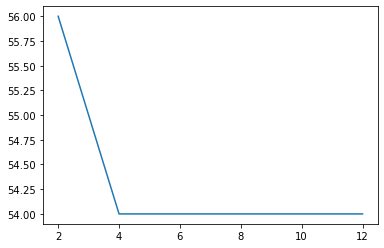

In [191]:
prue_plot(top_params, X_train, X_test, y_train, y_test)

In [173]:
top_params['criterion']

'entropy'

<a id="8.Report"></a>
# 8.Report
<a href="#1.Summary">Click this Link back to Top</a>

In [224]:
def main_function():
    """
    """
    data_path = "03_data/13_Titanic.csv"
    # Step 1 Read and Split
    print("*"*30, "Step 1 Read and Split", "*"*30)
    X_train, X_test, y_train, y_test, df = read_split(data_path)
    
    # Step 2 fit DecisionTree function
    print("*"*30, "Step 2 fit DecisionTree function", "*"*30)
    image_path_1 = "04_images/14_titanic_DT.png"
    clf = fit_plot(X_train, X_test, y_train, y_test, image_path_1)
    display(Image(filename=image_path_1))
    
    # Step 3 performance measures
    print("*"*30, "Step 3 performance measures", "*"*30)
    measures(X_train, X_test, y_train, y_test, df, clf)
    
    # Step 4 use cross validation find best paramters
    print("*"*30, "Step 4 use cross validation find best paramters", "*"*30)
    top_params = gridsearch(X_train, y_train,clf)
    
    # Step 5 Prune Tree with best paramtesrs and plot 
    print("*"*30, "Step 5 Prune Tree with best paramtesrs and plot ", "*"*30)
    prune_grid = prue_plot(top_params, X_train, X_test, y_train, y_test)
    plt.show()
    
    # Step 6 plot best pruning tree model 
    print("*"*30, "Step 6 plot best pruning tree model ", "*"*30)
    image_path_2 = "04_images/15_Best_DescionTree.png"
    #clf = DecisionTreeClassifier(max_depth=4,**prune_grid)
    clf_history = fit_plot(X_train, X_test, y_train, y_test, image_path_2, prune_grid)
    display(Image(filename=image_path_2))
    return X_train, X_test, y_train, y_test, df, clf, top_params
    

****************************** Step 1 Read and Split ******************************
****************************** Step 2 fit DecisionTree function ******************************
accuracy: 0.7862595419847328


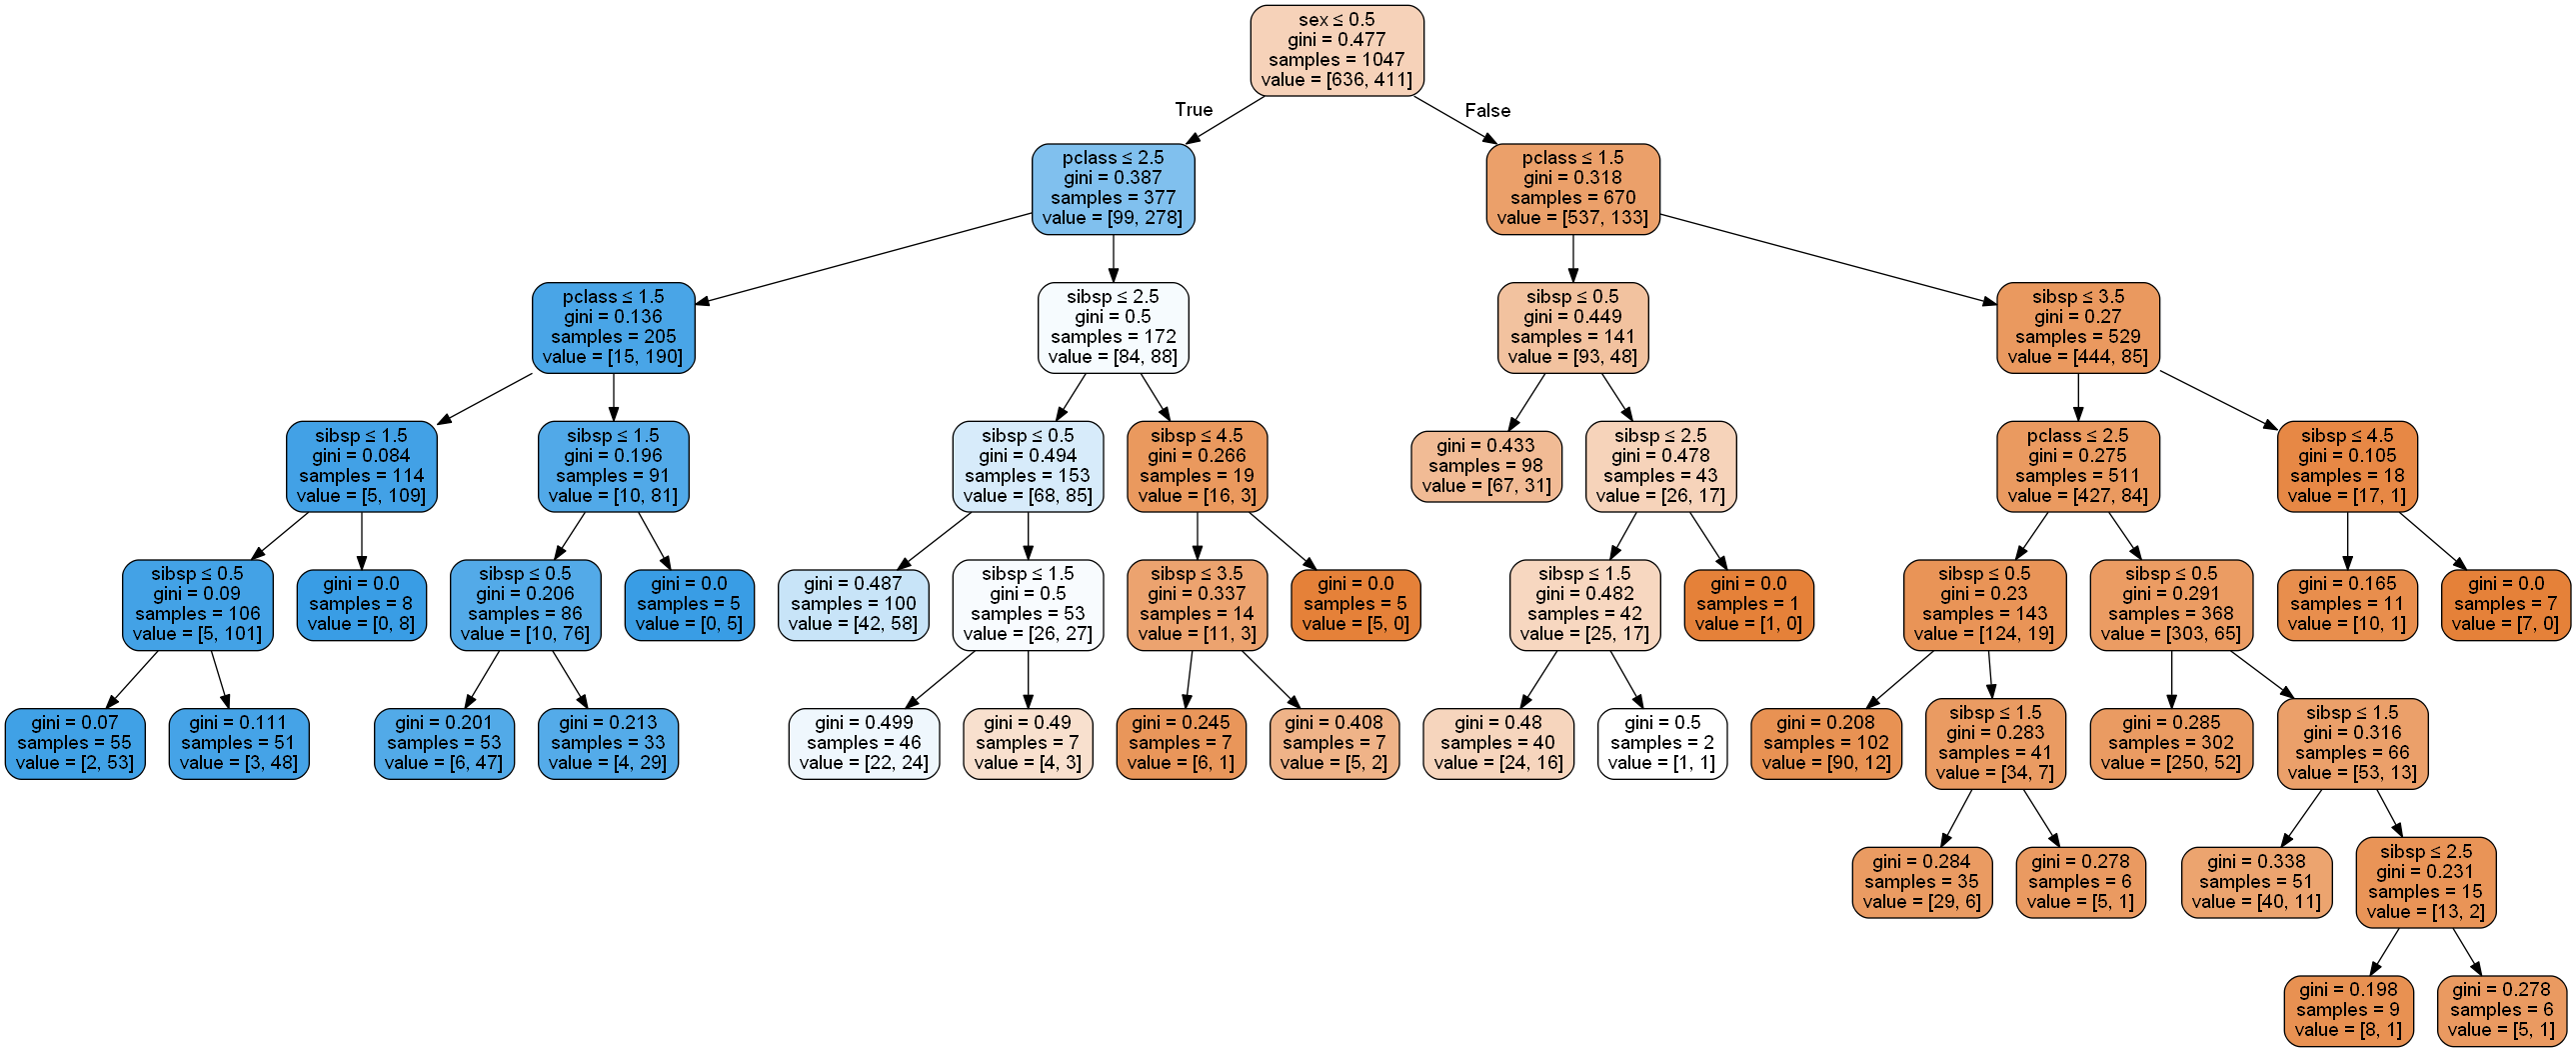

****************************** Step 3 performance measures ******************************
test
[[557  79]
 [139 272]]
in-sample percent survivors correctly predicted 66.18%
in-sample percent fatalities correctly predicted 87.58%
test
[[147  26]
 [ 30  59]]
out-sample percent survivors correctly predicted 66.29%
out-sample percent fatalities correctly predicted 84.97%
****************************** Step 4 use cross validation find best paramters ******************************
-- Grid Parameter Search via 5-fold CV

GridSearchCV took 11.62 seconds for 18 candidate parameter settings.
Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}
mean: 0.776 (std: 0.029)

****************************** Step 5 Prune Tree with best paramtesrs and plot  ******************************


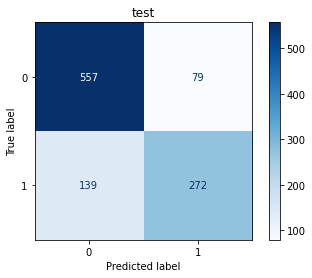

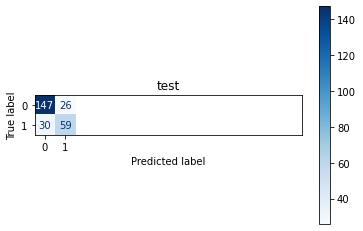

****************************** Step 6 plot best pruning tree model  ******************************
accuracy: 0.7938931297709924


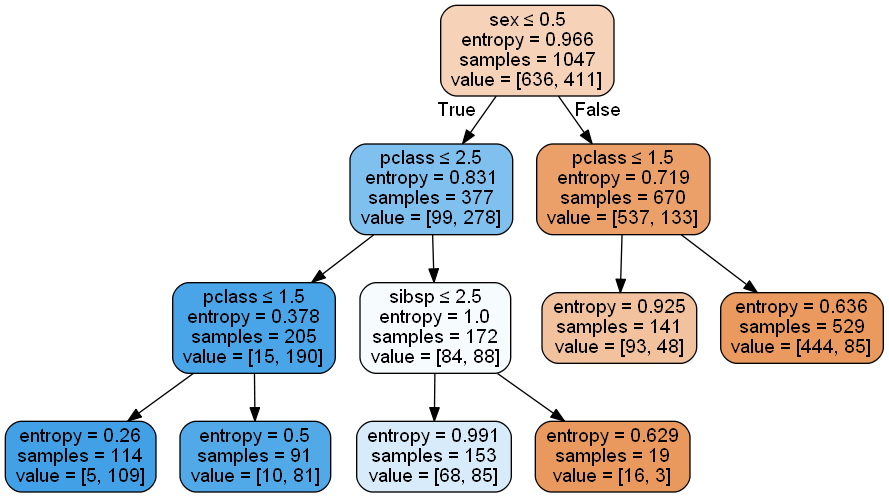

In [225]:
if __name__=="__main__":
    X_train, X_test, y_train, y_test, df, clf,top_params = main_function()

<br>

<br>

<br>

<a id="9.Discussion"></a>
# 9.Discussion
<a href="#1.Summary">Click this Link back to Top</a>

<font color='red'>Accuracy has imporoved from 78% to 79%</font>

<br>

<br>

<a id="10.Unused Code"></a>
# 10.Unused Code
<a href="#1.Summary">Click this Link back to Top</a>

In [ ]:
# <ol>
#     <li><a href="#1.Summary">Summary</a></li>
#     <li><a href="#2.Tabole of Contents">Tabole of Contents</a></li>
#     <li><a href="#3.Read and Plot">Read and Plot</a></li>
#     <li><a href="#4.Pre-train Function">Pre-train Function</a></li>
#     <li><a href="#5.Data Split">Data Split</a></li>
#     <li><a href="#6.Loss function">Loss Function</a></li>
#     <li><a href="#7.Train Modules">Train Modules</a></li>
#     <ul>
#        <li><a href="#7.1 Normal Equation">7.1 Gradien Descent</a></li>
#        <li><a href="#7.2 Batch Gradient Descent">7.2 Batch Gradient Descent</a></li> 
#        <li><a href="#7.3 Vanilla Gardient Descent with matrix">7.3 Vanilla Gardient Descent with matrix</a></li>
#        <li><a href="#7.4 Stochastic Gardent Descent">7.4 Stochastic Gardent Descent</a></li> 
#        <li><a href="#7.5 Mini-batch Gradient Descent">7.5 Mini-batch Gradient Descent</a></li> 
#     </ul>
#     <li><a href="#8.Plot Function">Plot Function</a></li>
#     <li><a href="#9.Main Function">Main Function</a></li>
#     <li><a href="#10.Unused Code">Unused Code</a></li>
# </ol> -->

In [211]:
# data_path = "03_data/13_Titanic.csv"
# df_10 = pd.read_csv(data_path)

# df_10.shape

# df_10.groupby("pclass").count()

# df_10['pclass']==

# df_10[df_10['pclass']=='1st'].loc["pclass"] = 1

# df_10.fillna(0)

# df_10['pclass'] = df_10['pclass'].map({'1st': 1, '2nd': 2, '3rd':3}).astype(int)

# df_10.groupby("pclass").count()

# genders = {"male": 0, "female": 1}

# df_10['sex'] = df_10['sex'].map(genders)

# df_10.groupby("sibsp").count()

# df_10.groupby("age").count().index